In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [10]:
data = pd.read_csv('PJME_hourly (1).csv')
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

In [11]:
data

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [ ]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

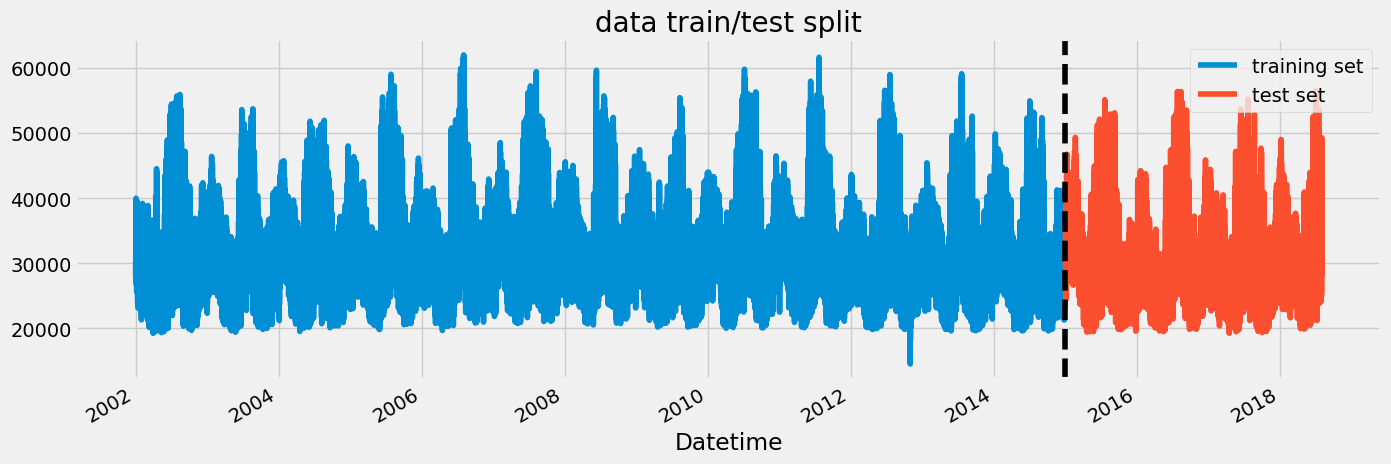

In [ ]:

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax = ax, label='training set', title='data train/test split')
test.plot(ax=ax, label='test set')
ax.axvline('01-01-2015', color = 'black', ls="--")
ax.legend(['training set', 'test set'])
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df = create_features(data)

Text(0.5, 1.0, 'MW By Hour')

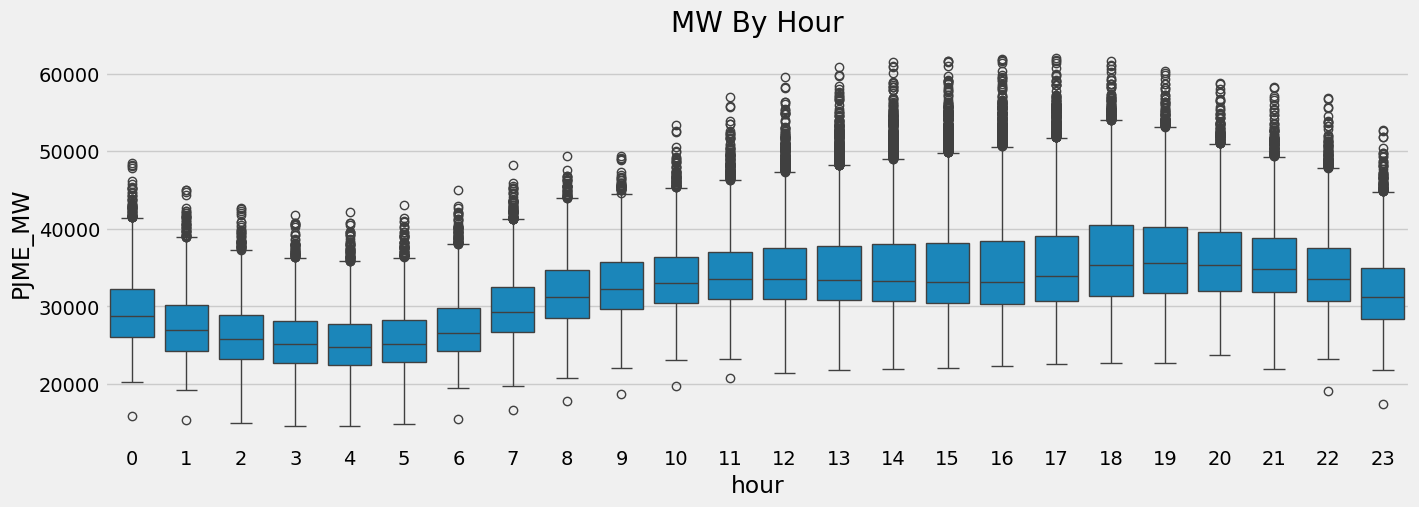

In [ ]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='hour',y='PJME_MW')
ax.set_title('MW By Hour')

Text(0.5, 1.0, 'MW By Month')

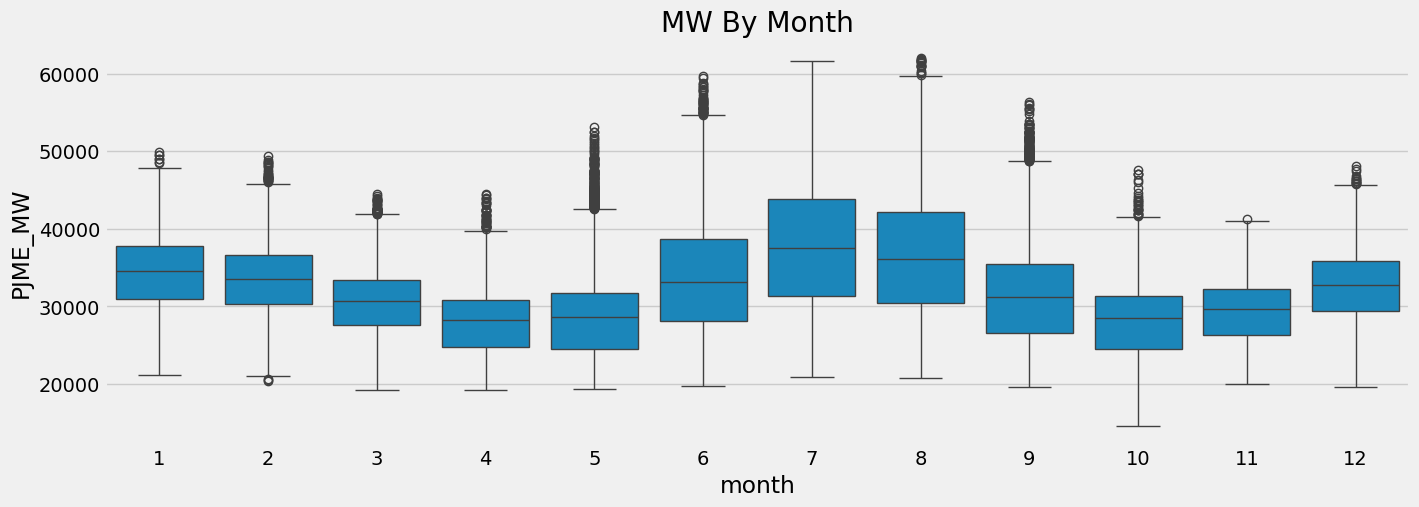

In [ ]:
fig, ax  = plt.subplots(figsize=(15,5))
sns.boxplot(df,x='month',y='PJME_MW')
ax.set_title('MW By Month')

In [ ]:
train= create_features(train)
test= create_features(test)

In [ ]:
FEATURES = [
 'hour',
 'dayofweek',
 'month',
 'quarter',
 'dayofyear',
 'year',
 'dayofmonth',
 'weekofyear']
TARGET= 'PJME_MW'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50,learning_rate= 0.1)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test, y_test)])

[0]	validation_0-rmse:6031.51893	validation_1-rmse:6031.51893
[1]	validation_0-rmse:5654.50549	validation_1-rmse:5654.50549
[2]	validation_0-rmse:5328.30848	validation_1-rmse:5328.30848
[3]	validation_0-rmse:5040.43982	validation_1-rmse:5040.43982
[4]	validation_0-rmse:4792.64442	validation_1-rmse:4792.64442
[5]	validation_0-rmse:4580.00837	validation_1-rmse:4580.00837
[6]	validation_0-rmse:4387.37579	validation_1-rmse:4387.37579
[7]	validation_0-rmse:4223.23709	validation_1-rmse:4223.23709
[8]	validation_0-rmse:4083.13254	validation_1-rmse:4083.13254
[9]	validation_0-rmse:3966.08420	validation_1-rmse:3966.08420
[10]	validation_0-rmse:3856.63694	validation_1-rmse:3856.63694
[11]	validation_0-rmse:3765.24555	validation_1-rmse:3765.24555
[12]	validation_0-rmse:3680.84595	validation_1-rmse:3680.84595
[13]	validation_0-rmse:3600.85719	validation_1-rmse:3600.85719
[14]	validation_0-rmse:3538.27737	validation_1-rmse:3538.27737
[15]	validation_0-rmse:3481.01901	validation_1-rmse:3481.01901
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'features importances')

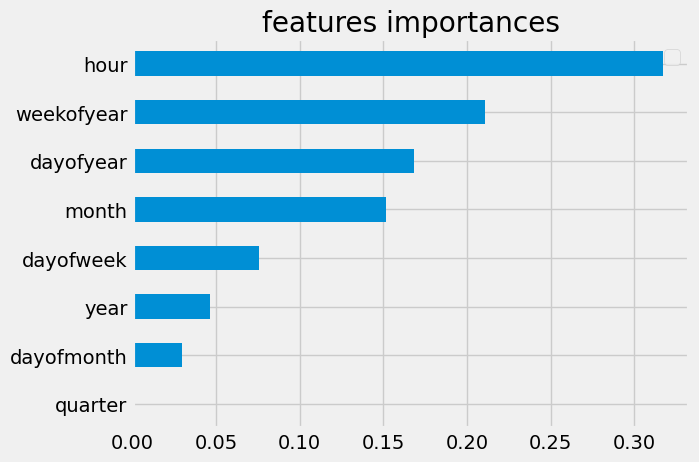

In [ ]:
feature_importances = pd.DataFrame(data=reg.feature_importances_,index= reg.feature_names_in_,columns=['importances'])
feature_importances = feature_importances.sort_values(by = 'importances', ascending=1)
feature_importances.plot(kind='barh')
plt.legend('')
plt.title('features importances')

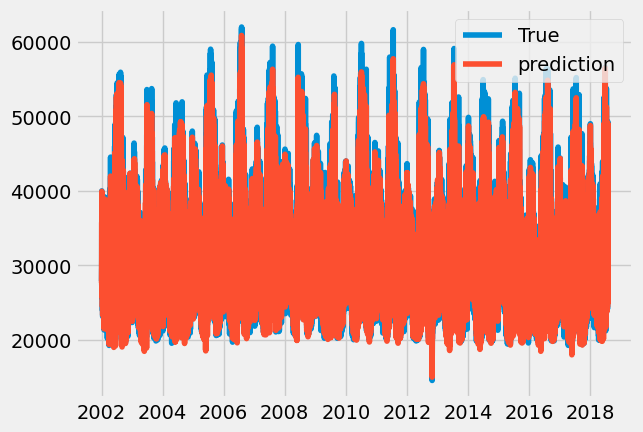

In [ ]:
test['prediction'] = reg.predict(X_test)
plt.plot(test['PJME_MW'],label='True')
plt.plot(test['prediction'],label='prediction')
plt.legend()

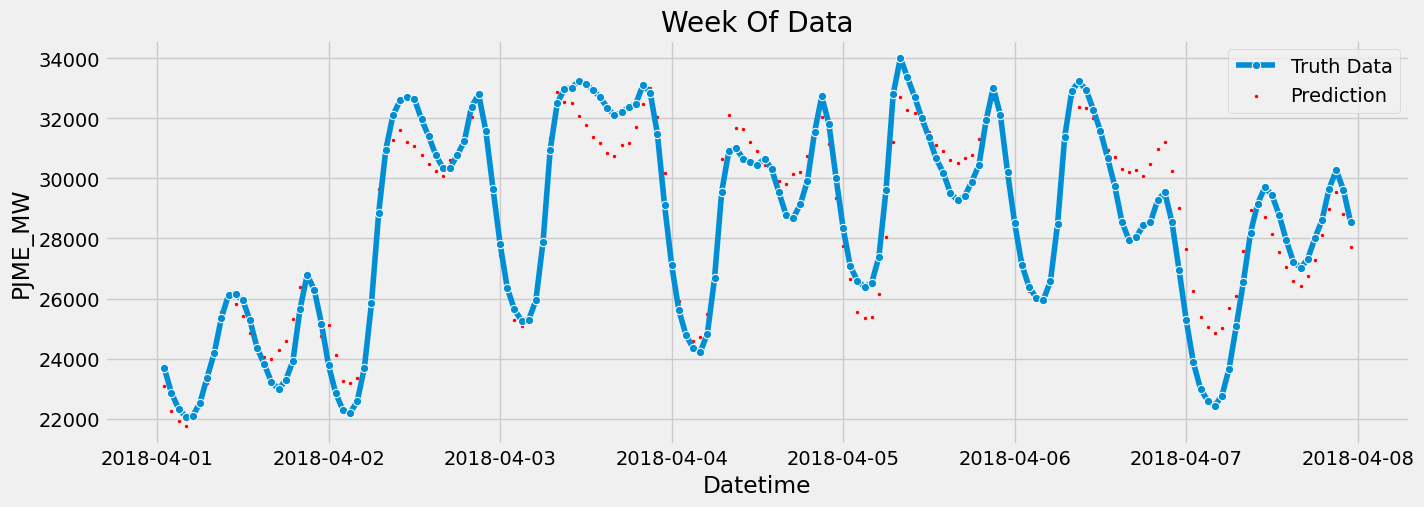

In [ ]:
filtered_data = test.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')]


plt.figure(figsize=(15, 5))
sns.lineplot(data=filtered_data['PJME_MW'], marker='o', label='Truth Data')
sns.scatterplot(data=filtered_data['prediction'], marker='.', label='Prediction',color='red')
plt.title('Week Of Data')
plt.legend()
plt.show()


In [ ]:
mean_squared_error(test['PJME_MW'],test['prediction'])

1364661.2812326937

In [ ]:
test['error'] = test['PJME_MW'] - test['prediction']
test['abs_error'] = test['error'].apply(np.abs)
error_by_day = test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','prediction','error','abs_error']]

In [ ]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW    prediction        error    abs_error
year month dayofmonth                                                      
2012 7     20          33980.250000  38193.378906 -4213.128255  4359.466634
2013 7     25          31583.375000  34875.660156 -3292.285238  3292.285238
           12          34658.666667  37837.269531 -3178.604574  3243.434001
2012 6     18          29457.375000  32512.843750 -3055.468424  3055.468424
           27          32282.416667  35315.691406 -3033.273682  3033.273682
2011 7     14          36260.958333  39268.550781 -3007.590332  3007.590332
2005 7     28          39144.541667  42047.828125 -2903.285726  3116.447184
2012 7     21          29097.083333  31680.337891 -2583.254964  2583.254964
2010 5     28          30958.833333  33537.402344 -2578.568197  2578.568197
     8     7           34340.458333  36902.320312 -2561.863200  2561.863200

In [ ]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW    prediction        error    abs_error
year month dayofmonth                                                      
2012 7     20          33980.250000  38193.378906 -4213.128255  4359.466634
     6     21          45850.125000  41909.261719  3940.861572  3940.861572
2008 6     7           38209.000000  35482.335938  2726.664958  3719.838298
2012 6     29          43444.250000  40127.316406  3316.933512  3708.005615
2014 6     18          42794.375000  39161.757812  3632.617188  3632.617188
2011 6     9           46009.500000  42557.398438  3452.101888  3611.755534
2007 6     8           39475.833333  37220.062500  2255.771403  3608.969482
2014 9     6           37945.833333  34388.679688  3557.152832  3557.152832
2005 3     8           33735.125000  33641.722656    93.399984  3477.728597
2004 8     21          35298.000000  34052.714844  1245.285726  3361.721598

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW    prediction       error   abs_error
year month dayofmonth                                                    
2006 12    15          31790.041667  31838.914062  -48.871908  115.667969
2004 12    28          37640.291667  37658.820312  -18.529460  118.657715
2011 10    17          27912.125000  28006.125000  -94.000570  126.835693
     4     19          28441.708333  28450.140625   -8.432943  134.554199
2015 10    7           27375.041667  27499.625000 -124.583740  135.578044
2005 10    11          29859.791667  29763.568359   96.223551  146.017985
2011 10    24          28256.791667  28246.703125   10.087240  150.332031
2005 10    4           31699.083333  31720.476562  -21.393636  152.381266
2013 10    20          23930.916667  23918.306641   12.608073  152.436523
2015 12    31          27803.875000  27815.726562  -11.852620  157.135010